# Issues need to be solved:
1. Potential array interpolation.

    For a 3-dimensional interpolation, there could be also **_nearest_, _linear_ and _cubic_** methods. [Wiki on multivariate interpolation.](https://en.wikipedia.org/wiki/Interpolation)  [Scipy.interpolate](https://docs.scipy.org/doc/scipy-0.18.1/reference/interpolate.html) provides several functions for high dimension interpolation. [RegularGridInterpolation](https://docs.scipy.org/doc/scipy-0.18.1/reference/generated/scipy.interpolate.RegularGridInterpolator.html#scipy.interpolate.RegularGridInterpolator) only provides linear and nearest methods, which might be insufficient for our field potential interpolation. [GridData function](https://docs.scipy.org/doc/scipy-0.18.1/reference/generated/scipy.interpolate.griddata.html#scipy.interpolate.griddata) provides (1-d or 2-d) cubic interpolation, which might match our request.
    
2. Units.

    In the trajectory calculation, length in unit of mm, time in unit of us, velocity in unit of mm/us, charge in unit of e, mass in unit of atomic unit mass 
    
3. Trajectories iteration or 2nd [ODE solution](https://docs.scipy.org/doc/scipy-0.13.0/reference/integrate.html)
    
    [ode](https://docs.scipy.org/doc/scipy-0.13.0/reference/generated/scipy.integrate.ode.html#scipy.integrate.ode)
    
    [odein](https://docs.scipy.org/doc/scipy-0.13.0/reference/generated/scipy.integrate.odeint.html)
    
    Vector function integration using [Runge-Kutta methods](https://rosettacode.org/wiki/Runge-Kutta_method) or Euler
    Should the gradient force be calculated everytime iteration is made or should it be calculated at once.
    
    
## To-Do
1. Integration method problem. [Change iteration algorithms](http://stackoverflow.com/questions/19779217/need-help-solving-a-second-order-non-linear-ode-in-python)
Runge-Kutta method?

2. Interpolation and gradient calculation step.

3. Change electrodes potentials to the current setup. Single ion trajectory as function of time. in Runge-Kutta integration.

4. Simulate detected signal.

5. Time resolution

6. Define MCP detection area and ion stop condition

11.08: When doing Gradient/Electric force calculation, spatial step is important

### Import potentials and coordinates from HDF5 file

In [1]:
import h5py
import numpy as np
import pandas as pd
from scipy.interpolate import RegularGridInterpolator as rgi
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import axes3d

In [2]:
#Potential field are stored in a HDF5 file
f=h5py.File('PA_v4.hdf5','r')

In [3]:
for name in f:
    print name

Coordinates
Potential Arrays
iselectrode


In [4]:
#coordinates x,y,z in unit of mm
x=f["Coordinates/X"].value/2.
y=f["Coordinates/Y"].value/2.
z=f["Coordinates/Z"].value/2.

### Set electrodes potentials and calculate spatial potential values
19 electrodes are set to certain potentials to create electric field to ionize Rydberg atoms

In [5]:
#set values of 19 electrodes, for ionization field of state n=30
#electrode_set_potentials=[187.*1.2,187.*1.2,-1.74,-278.*1.2,-0.114*1.2,-1900.,0.,3.97*1.2,-1.74*1.2,-278.*1.2,187.*1.2,187.*1.2,0.3*1.2,-278.*1.2,0.,0.,0.,0.318*1.2,0.307*1.2];
electrode_set_potentials=[187.,187.,-1.74,-278.,-0.114,-1900.,0.,3.97,-1.74,-278.,187.,187.,0.3,-278.,0.,0.,0.,0.318,0.307];

In [6]:
# generate potential by setting each electrode to its potential and adding up all electrodes' potential
potentials=np.zeros((len(x),len(y),len(z)))
for i in range(19):
    electroden=f["Potential Arrays/electrode"+str(i+1)].value
    potentials+=electrode_set_potentials[i]*electroden/10000.

### Interpolate potential arrays and plot cross sections for comparison

In [7]:
#generate potential interpolation

from scipy.interpolate import RegularGridInterpolator as rgi
p_interpolation=rgi((x,y,z),potentials)

### Calculate single ion trajectory

Define velocity iteration function and trajectory iteration function for single ion.

MCP detector plane

In [8]:
mx=np.arange(-8,8,0.1)
my=np.arange(-8,8,0.1)

points=np.array([])

for i in mx:
    for j in my:
        if (i**2+j**2)<= 7.25**2:
            points=np.append(points,([i,j,3]))

points=points.reshape((len(points)/3,3))

phi=-82.*np.pi/180.
tmatrix=np.array([[np.cos(phi),0,-np.sin(phi)],
           [0,1,0],
           [np.sin(phi),0,np.cos(phi)]])

MCPgrid=np.array([tmatrix.dot(i) for i in points])*2 + [247,205,214]
MCP=MCPgrid/2

In [9]:
#center point of MCP plane
center=(tmatrix.dot(np.array([0.,0.,3.]))*2 + [247,205,214])/2
#c=(241+6*np.cos(phi) + np.tan(- phi)*(247 + 6*np.sin( - phi)))/2.
c=center[2] + np.tan(- phi)* center[0]
center, c

(array([ 126.47080421,  102.5       ,  107.4175193 ]), 1007.3040503174313)

<IPython.core.display.Javascript object>


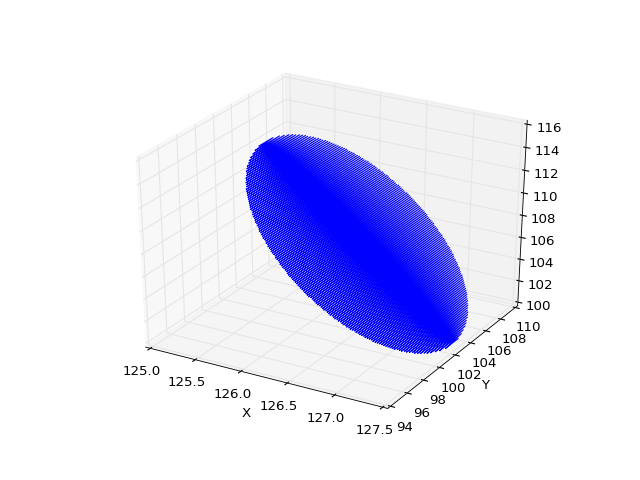

In [10]:
%matplotlib notebook
mcpplot=plt.figure()
mp=mcpplot.add_subplot(111,projection='3d')
mp.plot(MCP[:,0],MCP[:,1],MCP[:,2],label='MCP')
#mp.plot(points[:,0],points[:,1],points[:,2])
plt.xlabel("X")
plt.ylabel("Y")
plt.show()

In [11]:
#single ion's position and velocity iteration functions

def R(ri,vi,dt):                  #delta_t in unit of micro-second, displacement in unit of mm, v in unit of mm/us
    x_new=ri[0]+vi[0]*dt
    y_new=ri[1]+vi[1]*dt
    z_new=ri[2]+vi[2]*dt
    return np.array([x_new,y_new,z_new])

def V(ri,vi,delta_t,dr):
    dvx=-100./(1.0364*87.) * (p_interpolation([ri[0]+dr,ri[1],ri[2]])[0]-p_interpolation([ri[0]-dr,ri[1],ri[2]])[0])/(dr*2) #- for positive ions, + for electrons
    dvy=-100./(1.0364*87.) * (p_interpolation([ri[0],ri[1]+dr,ri[2]])[0]-p_interpolation([ri[0],ri[1]-dr,ri[2]])[0])/(dr*2)
    dvz=-100./(1.0364*87.) * (p_interpolation([ri[0],ri[1],ri[2]+dr])[0]-p_interpolation([ri[0],ri[1],ri[2]-dr])[0])/(dr*2)
    vx_new=vi[0]+dvx * dt
    vy_new=vi[1]+dvy * dt
    vz_new=vi[2]+dvz * dt
    return np.array([vx_new,vy_new,vz_new])

def VCoul(ra,rb):
    #coulombic acceleration of Rb ion at ra, due to repulsion of Rb ion at rb
    distance=np.linalg.norm(ra-rb)
    coulf=1.595 * 1.e-6 /distance**2
    return (ra-rb)*coulf/distance
    

def cross_ratio(r_n,r_iter,count,dt):
    x1=r_n[0]
    z1=r_n[2]
    x2=r_iter[0]
    z2=r_iter[2]
    a=np.array([[np.tan(-phi),1.],[(z2-z1)/(x1-x2),1]])
    b=np.array([c,(x1*z2-x2*z1)/(x1-x2)])
    
    r_p= np.linalg.solve(a,b)
    ratio=(r_p[0]-r_n[0])/(r_iter[0]-r_n[0])
    count += ratio
    y_p= r_n[1] +(r_iter[1]-r_n[1])*ratio
    t=count*dt
    r_new= [np.sign(r_p[1]-center[2]) * np.sqrt((r_p[0]-center[0])**2 + (r_p[1]-center[2])**2),y_p-center[1],t]
    return r_new



def nstop(r):
    xx=r[0]
    zz=r[2]
    if (zz+np.tan(phi)*xx)< c :
        return True
    else:
        return False

**Distance step when calculating gradient has significant fluence on the trajectories**

In [12]:
dr=0.5       #dr[mm] is used when calculating gradients
dt=0.01     #dt[us]

In [13]:
def trajectory(r_init,v_init,dt):
    v_iter=np.zeros((1,3))
    r_iter=np.zeros((1,3))
    r_iter[0]=r_init
    v_iter[0]=v_init 
    count=0              #no appending?
    while (r_iter[-1]>[x[1],y[1],z[1]]).all() and (r_iter[-1]<[x[-2],y[-2],z[-2]]).all() and (r_iter[-1][2]-np.tan(phi)*r_iter[-1][0]<=c):
        # while loop condition: ion still in effective volume, and not hit the plane
        v_iter=np.append(v_iter,[V(r_iter[-1],v_iter[-1],dt,dr)],0)
        r_iter=np.append(r_iter,[R(r_iter[-1],v_iter[-1],dt)],0)
        count+=1
        if count*dt>20:
            break
        
    r=r_iter
    v=v_iter
    t=len(r_iter)*dt
    return [r,v,t]

def trajectory2(r_init,v_init,dt):
    r_iter=r_init
    v_iter=v_init 
    r_n=r_init
    count=0              #no appending?
    while (r_iter>[x[1],y[1],z[1]]).all() and (r_iter<[x[-2],y[-2],z[-2]]).all() and (r_iter[2]-np.tan(phi)*r_iter[0]<=c):
        # while loop condition: ion still in effective volume, and not hit the plane
        r_n=r_iter
        v_iter=V(r_iter,v_iter,dt,dr)
        r_iter=R(r_iter,v_iter,dt)
        count+=1
        if count*dt>20:
            break
        
    x1=r_n[0]
    z1=r_n[2]
    x2=r_iter[0]
    z2=r_iter[2]
    a=np.array([[np.tan(-phi),1.],[(z2-z1)/(x1-x2),1]])
    b=np.array([c,(x1*z2-x2*z1)/(x1-x2)])
    
    r_p= np.linalg.solve(a,b)
    v=v_iter
    ratio=(r_iter[0]-r_p[0])/(r_iter[0]-r_n[0])
    count += ratio
    y_p= r_n[1] +(r_iter[1]-r_n[1])*ratio
    t=count*dt
    r_new= [np.sign(r_p[1]-center[2]) * np.sqrt((r_p[0]-center[0])**2 + (r_p[1]-center[2])**2),y_p-center[1],t]
    
    return [r_new,v]

def trajectories_two_ions(r_init1,v_init1,r_init2,v_init2,dt):
    r_iter1=r_init1
    v_iter1=v_init1
    r_iter2=r_init2
    v_iter2=v_init2
    r_n1=r_init1
    r_n2=r_init2
    count1=0
    count2=0
    #no appending?
    condition1=(r_iter1>[x[1],y[1],z[1]]).all() and (r_iter1<[x[-2],y[-2],z[-2]]).all() and (r_iter1[2]-np.tan(phi)*r_iter1[0]<=c)
    condition2=(r_iter2>[x[1],y[1],z[1]]).all() and (r_iter2<[x[-2],y[-2],z[-2]]).all() and (r_iter2[2]-np.tan(phi)*r_iter2[0]<=c)
    while condition1 or condition2:
        # while loop condition: ion still in effective volume, and not hit the plane
        iondistance=np.linalg.norm(r_iter1-r_iter2)
        """if iondistance<0.01:
            dt=0.0001
        else:
            dt=0.01"""
        if condition1:
            r_n1=r_iter1
            v_iter1=V(r_iter1,v_iter1,dt,dr) + (condition1 and condition2)*VCoul(r_iter1,r_iter2)*dt
            r_iter1=R(r_iter1,v_iter1,dt)
            count1+=1
        if condition2:
            r_n2=r_iter2
            v_iter2=V(r_iter2,v_iter2,dt,dr) + (condition1 and condition2)*VCoul(r_iter2,r_n1)*dt
            r_iter2=R(r_iter2,v_iter2,dt)
            count2+=1*condition2
        
        if max(count1*dt,count2*dt)>15:
            break
            
        condition1=(r_iter1>[x[1],y[1],z[1]]).all() and (r_iter1<[x[-2],y[-2],z[-2]]).all() and (r_iter1[2]-np.tan(phi)*r_iter1[0]<=c)
        condition2=(r_iter2>[x[1],y[1],z[1]]).all() and (r_iter2<[x[-2],y[-2],z[-2]]).all() and (r_iter2[2]-np.tan(phi)*r_iter2[0]<=c)
        
    #map coordinates into detector plane coordinate
    r_new1=cross_ratio(r_n1,r_iter1,count1,dt)
    r_new2=cross_ratio(r_n2,r_iter2,count2,dt)
    v1=v_iter1
    v2=v_iter2
    #displacement=np.array(r_new1) - np.array(r_new2)
    
    return [r_new1,v1,r_new2,v2]

### Coulomb interaction influence

In [14]:
#Starting point r0 and initial velocity v0
r0=np.array([94.5,102.5,55.5])
v0=np.array([0,0,0])
[f10,v10]=trajectory2(r0,v0,dt)
f10,v10

([0.27608091170657961, 0.069906204468793476, 4.4917916905373669],
 array([ 62.59098621,   0.063188  ,  12.78745611]))

In [120]:
d=np.linspace(5.e-4,0.01,10)
Dx1=np.zeros(len(d))
Dx2=np.zeros(len(d))
Dx=np.zeros(len(d))
Dtx1=np.zeros(len(d))
Dtx2=np.zeros(len(d))
ion10=np.zeros((len(d),3))
ion1=np.zeros((len(d),3))
ion20=np.zeros((len(d),3))
ion2=np.zeros((len(d),3))
r0=np.array([94.5,102.5,55.5])
f1=np.zeros((1,3))
v1=np.zeros((1,3))
f2=np.zeros((1,3))
v2=np.zeros((1,3))
f20=np.zeros((1,3))
v20=np.zeros((1,3))
r1=np.zeros((1,3))
r2=np.zeros((1,3))
for i in range(len(d)):
    r1=r0
    r2=r0 + [d[i],0,0]
    [f20,v20]=trajectory2(r2,v0,dt)
    ion10[i]=f10
    ion20[i]=f20
    [f1,v1,f2,v2]=trajectories_two_ions(r1,v0,r2,v0,dt)
    ion1[i]=f1
    ion2[i]=f2
    Dx1[i]=np.linalg.norm((np.array(f10)-np.array(f1))[:2])
    Dx2[i]=np.linalg.norm((np.array(f20)-np.array(f2))[:2])
    Dx[i]=np.linalg.norm((np.array(f1)-np.array(f2))[:2] - (np.array(f10)-np.array(f20))[:2])
    Dtx1[i]=f1[2]-f10[2]
    Dtx2[i]=f2[2]-f20[2]
    print r2,f20,f2

[  94.5005  102.5      55.5   ] [0.27525123647357003, 0.069971148616275514, 4.4918677828230384] [-0.03578200808368092, 0.078180325558989239, 4.4688808294667997]
[  94.50155556  102.5          55.5       ] [0.27350297414371516, 0.070108228352793844, 4.492028054671052] [0.13571826842624671, 0.073745608415109132, 4.485377300521173]
[  94.50261111  102.5          55.5       ] [0.27175908794009301, 0.070245276812386237, 4.4921878052122768] [0.16908636723605483, 0.072974579633481085, 4.4884206369248867]
[  94.50366667  102.5          55.5       ] [0.27001953051113131, 0.070382288011856531, 4.4923469911016847] [0.18641208502288212, 0.072615699649276166, 4.4901174449280896]
[  94.50472222  102.5          55.5       ] [0.26828328194128198, 0.070519308515486046, 4.4925056633280755] [0.19690310292995966, 0.072419789699864623, 4.4911595376211819]
[  94.50577778  102.5          55.5       ] [0.26655021052720645, 0.070656347393011742, 4.4926638101647347] [0.2034111889203285, 0.072307304607292622, 4.

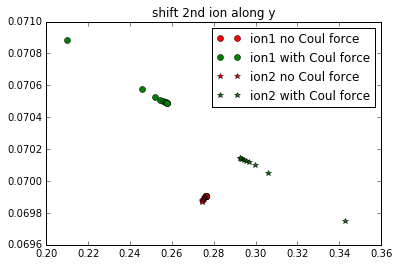

In [117]:
%matplotlib inline
plt.plot(ion10[:,0],ion10[:,1],'ro',label='ion1 no Coul force')
plt.plot(ion1[:,0],ion1[:,1],'go',label='ion1 with Coul force')
plt.plot(ion20[:,0],ion20[:,1],'r*',label='ion2 no Coul force')
plt.plot(ion2[:,0],ion2[:,1],'g*',label='ion2 with Coul force')
plt.title("shift 2nd ion along y")
plt.legend(loc='best')
plt.show()

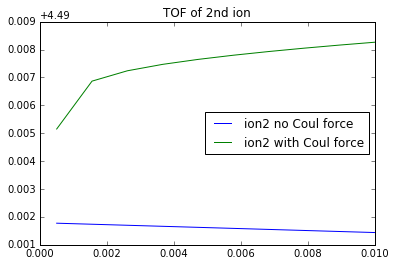

In [119]:
plt.plot(d,ion20[:,2],label='ion2 no Coul force')
plt.plot(d,ion2[:,2],label='ion2 with Coul force')
plt.title("TOF of 2nd ion")
plt.legend(loc='best')
plt.show()

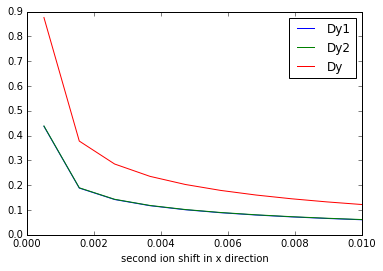

In [115]:
%matplotlib inline
plt.plot(d,Dx1,label='Dy1')
plt.plot(d,Dx2,label='Dy2')
plt.plot(d,Dx,label='Dy')
#plt.plot(d,Dtx2,label='Dtx1')
plt.xlabel("second ion shift in x direction")
plt.legend(loc='best')
plt.show()

In [121]:
d=np.linspace(5.e-4,0.01,10)
#d=np.logspace(-4,0,20)
Dy1=np.zeros(len(d))
Dy2=np.zeros(len(d))
Dy=np.zeros(len(d))
Dty1=np.zeros(len(d))
Dty2=np.zeros(len(d))
r0=np.array([94.5,102.5,55.5])
f1=np.zeros((1,3))
v1=np.zeros((1,3))
f2=np.zeros((1,3))
v2=np.zeros((1,3))
f20=np.zeros((1,3))
v20=np.zeros((1,3))
for i in range(len(d)):
    r1=r0
    r2=r0+[0,d[i],0]
    [f20,v20]=trajectory2(r2,v0,dt)
    [f1,v1,f2,v2]=trajectories_two_ions(r1,v0,r2,v0,dt)
    Dy1[i]=np.linalg.norm((np.array(f10)-np.array(f1))[:2])
    Dy2[i]=np.linalg.norm((np.array(f20)-np.array(f2))[:2])
    Dy[i]=np.linalg.norm((np.array(f1)-np.array(f2))[:2] - (np.array(f10)-np.array(f20))[:2])
    Dty1[i]=f1[2]-f10[2]
    Dty2[i]=f2[2]-f20[2]
    print f2,f20

[0.25693363787935347, 0.50882470249725031, 4.4972410050713512] [0.27602775566512938, 0.070441348219873134, 4.4917950606166244]
[0.26788111233929418, 0.26089900040868486, 4.4977997252597133] [0.27592360670126798, 0.071572295385379903, 4.49180210597528]
[0.26986180401039089, 0.21579955334999568, 4.4978996637849535] [0.27582585392200198, 0.072704210148359039, 4.4918091064885184]
[0.2708885313036436, 0.19206630608105968, 4.4979499848016644] [0.27573271313185838, 0.073836841502725292, 4.4918160746137215]
[0.27153412018229589, 0.17681232394519952, 4.4979802246399467] [0.27564312105742739, 0.074970063063062753, 4.4918230241131409]
[0.27197972329953346, 0.16598045211996748, 4.4979998064516655] [0.27555647739382894, 0.076103797412386598, 4.4918299565360584]
[0.27230408399854866, 0.15781735428220145, 4.4980128667451975] [0.27547221512318332, 0.077237985847361301, 4.491836880505149]
[0.27254792600914818, 0.15142202364005186, 4.4980215680982898] [0.27538980778418537, 0.078372588051593084, 4.491843

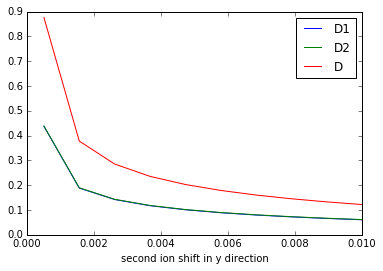

In [120]:
%matplotlib inline
plt.plot(d,Dy1,label='D1')
plt.plot(d,Dy2,label='D2')
plt.plot(d,Dy,label='D')
#plt.plot(d,Dty2,label='Dty1')
plt.xlabel("second ion shift in y direction")
plt.legend(loc='best')
plt.show()

In [122]:
d=np.linspace(5.e-4,0.01,10)
Dz1=np.zeros(len(d))  
Dz2=np.zeros(len(d))
Dz=np.zeros(len(d))
Dtz1=np.zeros(len(d))
Dtz2=np.zeros(len(d))
r0=np.array([94.5,102.5,55.5])
f1=np.zeros((1,3))
v1=np.zeros((1,3))
f2=np.zeros((1,3))
v2=np.zeros((1,3))
f20=np.zeros((1,3))
v20=np.zeros((1,3))
for i in range(len(d)):
    r1=r0
    r2=r0+[0,0,d[i]]
    [f20,v20]=trajectory2(r2,v0,dt)
    [f1,v1,f2,v2]=trajectories_two_ions(r1,v0,r2,v0,dt)
    Dz1[i]=np.linalg.norm((np.array(f10)-np.array(f1))[:2])
    Dz2[i]=np.linalg.norm((np.array(f20)-np.array(f2))[:2])
    Dz[i]=np.linalg.norm((np.array(f1)-np.array(f2))[:2] - (np.array(f10)-np.array(f20))[:2])
    Dtz1[i]=f1[2]-f10[2]
    Dtz2[i]=f2[2]-f20[2]
    print f2,f20

[0.34274089182919204, 0.069748556205837531, 4.4951506354061648] [0.27598500664039016, 0.069904451225824005, 4.4917741376513396]
[0.30607680968995948, 0.070051382777492677, 4.4968664956647277] [0.27578270894963436, 0.069900740209533296, 4.4917370531322343]
[0.29987296852560485, 0.070098398728944744, 4.4972371088208556] [0.27558050617297192, 0.06989702862514946, 4.4916999399761259]
[0.29697043656583832, 0.070118317604723757, 4.4974678194919981] [0.27537854167291326, 0.069893312004978725, 4.4916627924627468]
[0.29533034784764406, 0.070128301294076323, 4.4976451291072443] [0.27517639960973928, 0.069889598836311961, 4.4916256249751418]
[0.29430354613031967, 0.07013378041864371, 4.4977948305050761] [0.27497435407510379, 0.069885885093469824, 4.4915884287240857]
[0.29361695656649167, 0.070137167739289907, 4.4979272702981969] [0.27477240560148292, 0.069882170773666985, 4.4915512036664431]
[0.29313107118008674, 0.070139698526418215, 4.4980474320824291] [0.27457055595047375, 0.069878455739214473

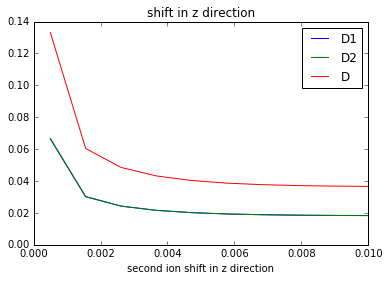

In [123]:
%matplotlib inline
plt.plot(d,Dz1,label='D1')
plt.plot(d,Dz2,label='D2')
plt.plot(d,Dz,label='D')
#plt.plot(d,Dtz2,label='Dtz1')
plt.xlabel("second ion shift in z direction")
plt.legend(loc='best')
plt.title("shift in z direction")
plt.show()

Coulombic interaction influence on displacement and TOF

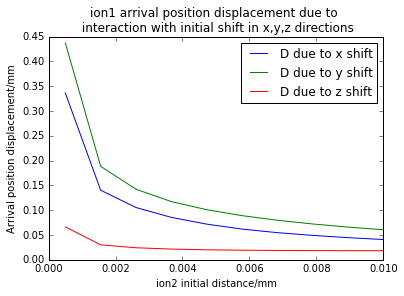

In [123]:
fig1=plt.figure()
plt.plot(d,Dx1,label='D due to x shift')
plt.plot(d,Dy1,label='D due to y shift')
plt.plot(d,Dz1,label='D due to z shift')
plt.title("ion1 arrival position displacement due to \n interaction with initial shift in x,y,z directions")
plt.legend(loc='best')
plt.xlabel('ion2 initial distance/mm')
plt.ylabel('Arrival position displacement/mm')
plt.show()

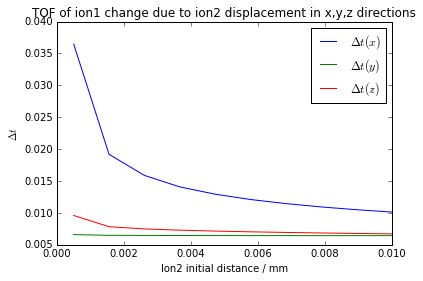

In [124]:
fig2=plt.figure()
plt.plot(d,Dtx1,label=r'$\Delta t(x)$')
plt.plot(d,Dty1,label=r'$\Delta t(y)$')
plt.plot(d,Dtz1,label=r'$\Delta t(z)$')
plt.legend(loc='best')
plt.title("TOF of ion1 change due to ion2 displacement in x,y,z directions")
plt.xlabel("Ion2 initial distance / mm")
plt.ylabel("$\Delta t$")
plt.show()

### Arrival position sensitiveness to initial position's offset

In [125]:
#[r,v,t]=trajectory(r0,v0,dt)
[r,v]=trajectory2(r0,v0,dt)
r,v

([0.27608091170657961, 0.069906204468793476, 4.4917916905373669],
 array([ 62.59098621,   0.063188  ,  12.78745611]))

In [126]:
d=np.arange(-5,5,0.2)
xd=np.zeros((len(d),4))
for k in range(len(d)):
    rr=np.array([94.5+d[k],102.5,55.5])
    [r,v]=trajectory2(rr,v0,dt)
    xd[k,0]=rr[0]
    xd[k,1]=r[0]
    xd[k,2]=r[1]
    xd[k,3]=r[2]
    
    print rr,r
    

[  89.5  102.5   55.5] [37.722417582158577, -0.12506675605270345, 4.0604125890269636]
[  89.7  102.5   55.5] [33.038402609130053, -0.19449978834636283, 4.4103260469101162]
[  89.9  102.5   55.5] [29.030094933960292, -0.25717233491675984, 4.75722568856831]
[  90.1  102.5   55.5] [25.708298300206973, -0.31403632533556447, 5.0621758376404573]
[  90.3  102.5   55.5] [22.898194892319797, -0.3682672670919942, 5.3546514715128515]
[  90.5  102.5   55.5] [20.404413340928809, -0.41861279835272569, 5.6276237890460088]
[  90.7  102.5   55.5] [18.300698659671042, -0.46101088527336742, 5.8736389805037366]
[  90.9  102.5   55.5] [15.819032739240251, -0.43640658497598395, 5.7113263488215074]
[  91.1  102.5   55.5] [13.62436883397071, -0.39794226140443811, 5.5414492907311006]
[  91.3  102.5   55.5] [11.651183451673241, -0.36905338188246617, 5.4052059392222747]
[  91.5  102.5   55.5] [10.078264061798762, -0.33487461883014191, 5.2889726364580643]
[  91.7  102.5   55.5] [9.1299730628364912, -0.30884511560

In [127]:
d=np.arange(-5,5,0.2)
yd=np.zeros((len(d),4))
for k in range(len(d)):
    rr=np.array([94.5,102.5+d[k],55.5])
    [r,v]=trajectory2(rr,v0,dt)
    yd[k,0]=rr[1]
    yd[k,1]=r[0]
    yd[k,2]=r[1]
    yd[k,3]=r[2]
    
    print rr,r

[ 94.5  97.5  55.5] [0.38484143090732448, -5.2886030977746401, 4.4974736327693936]
[ 94.5  97.7  55.5] [0.41188668374521492, -5.0811786487596322, 4.4954977249361798]
[ 94.5  97.9  55.5] [0.43347601720867296, -4.8674485243027306, 4.493788437609366]
[ 94.5  98.1  55.5] [0.44875841497196267, -4.6523443519639756, 4.4922225292684832]
[ 94.5  98.3  55.5] [0.46407040275507633, -4.4343751061919363, 4.4904328408602838]
[ 94.5  98.5  55.5] [0.46871656337447687, -4.2167384688914495, 4.5094217900117348]
[ 94.5  98.7  55.5] [0.47237089016330736, -4.0006729190868384, 4.5084222225724604]
[ 94.5  98.9  55.5] [0.47574250799426454, -3.7813565152373769, 4.5073102793374131]
[ 94.5  99.1  55.5] [0.4741969077831964, -3.5653093230800579, 4.5066677286317729]
[ 94.5  99.3  55.5] [0.47127120084555796, -3.3470799140910543, 4.5059992606513681]
[ 94.5  99.5  55.5] [0.46926575559495087, -3.1297687127910763, 4.5053234472423398]
[ 94.5  99.7  55.5] [0.46161260726631342, -2.9151979111564543, 4.5050892421344608]
[ 94.5

In [128]:
d=np.arange(-5,5,0.2)
zd=np.zeros((len(d),4))
for k in range(len(d)):
    rr=np.array([94.5,102.5,55.5+d[k]])
    [r,v]=trajectory2(rr,v0,dt)
    zd[k,0]=rr[2]
    zd[k,1]=r[0]
    zd[k,2]=r[1]
    zd[k,3]=r[2]
    
    print rr,r
    

[  94.5  102.5   50.5] [-4.2266507798354054, 0.18140582889581935, 4.2826120517425394]
[  94.5  102.5   50.7] [-4.1222214625004172, 0.17621142603876194, 4.2705500972434969]
[  94.5  102.5   50.9] [-3.9622987075615597, 0.17270031155399579, 4.2721511965872079]
[  94.5  102.5   51.1] [-3.6574378052524494, 0.17087442944627185, 4.288120682096574]
[  94.5  102.5   51.3] [-3.307599725094525, 0.16374023745893851, 4.2817477578934575]
[  94.5  102.5   51.5] [-2.9416614110191772, 0.15927237495431257, 4.2937581983617967]
[  94.5  102.5   51.7] [-2.5718997299258191, 0.15381709133967547, 4.3044478572568998]
[  94.5  102.5   51.9] [-2.2132682409779081, 0.14773976332762118, 4.31454888327346]
[  94.5  102.5   52.1] [-1.8038193620843024, 0.14128369190490275, 4.3246024379575463]
[  94.5  102.5   52.3] [-1.2707353179226664, 0.13433967998108187, 4.3328880544137611]
[  94.5  102.5   52.5] [-0.88597123820551915, 0.12731602492416982, 4.3409570125101462]
[  94.5  102.5   52.7] [-0.73680326179787281, 0.120933517

Final x' position of different initial position in x,y,z axes

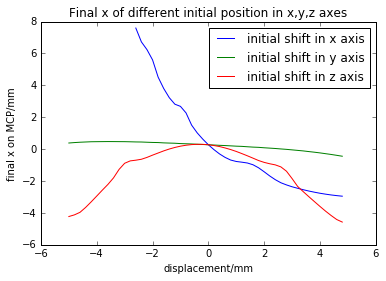

In [148]:
plt.plot(d[12:],xd[12:,1],label='initial shift in x axis')
plt.plot(d[0:],yd[0:,1],label='initial shift in y axis')
plt.plot(d[0:],zd[0:,1],label='initial shift in z axis')
plt.legend(loc='best')
plt.xlabel("displacement/mm")
plt.ylabel("final x on MCP/mm")
plt.title("Final x of different initial position in x,y,z axes")

Final y' position of different initial position in x,y,z axes

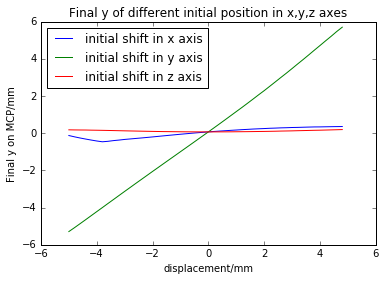

In [149]:
plt.plot(d[:],xd[:,2],label='initial shift in x axis')
plt.plot(d[:],yd[:,2],label='initial shift in y axis')
plt.plot(d[:],zd[:,2],label='initial shift in z axis')
plt.legend(loc='best')
plt.xlabel("displacement/mm")
plt.ylabel("Final y on MCP/mm")
plt.title("Final y of different initial position in x,y,z axes")

TOFs of different initial position in x,y,z axes

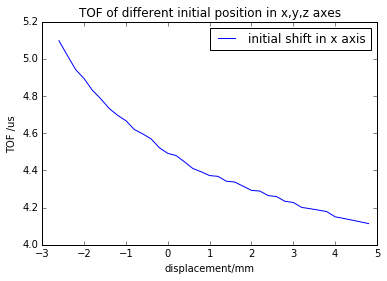

In [155]:
plt.plot(d[12:],xd[12:,3],label='initial shift in x axis')
#plt.plot(d[:],yd[:,3],label='initial shift in y axis')
#plt.plot(d[:],zd[:,3],label='initial shift in z axis')
plt.legend(loc='best')
plt.xlabel("displacement/mm")
plt.ylabel("TOF /us")
plt.title("TOF of different initial position in x,y,z axes")

In [83]:
d=np.arange(-3,3,0.2)
yd=np.zeros((len(d),4))
for k in range(len(d)):
    rr=np.array([102.5,102.5+d[k],65.])
    [r,v]=trajectory2(rr,v0,dt)
    yd[k,0]=rr[1]
    yd[k,1]=r[0]
    yd[k,2]=r[1]
    yd[k,3]=r[2]
    
    print rr,r
    

[ 102.5   99.5   65. ] [-8.7607628371658564, -5.8102388805285159, 3.4338710963683852]
[ 102.5   99.7   65. ] [-9.0802358803458567, -5.3855991153463805, 3.4044305544184619]
[ 102.5   99.9   65. ] [-9.2971388457567787, -4.9505195489747678, 3.3837273335920424]
[ 102.5  100.1   65. ] [-9.4602175213180644, -4.5162448568974156, 3.3775705956171396]
[ 102.5  100.3   65. ] [-9.6040008730359467, -4.2169099448058347, 3.3688813703713869]
[ 102.5  100.5   65. ] [-9.7478281134383682, -4.0511427706552467, 3.3560598919931794]
[ 102.5  100.7   65. ] [-9.9660943063762364, -3.7536198386415833, 3.3417681415078313]
[ 102.5  100.9   65. ] [-10.226715009384746, -3.3299049853047791, 3.3240008856410475]
[ 102.5  101.1   65. ] [-10.392211069289109, -2.7701696802629101, 3.3108235938504476]
[ 102.5  101.3   65. ] [-10.483463822088082, -2.2602247845761099, 3.3189200625188189]
[ 102.5  101.5   65. ] [-10.540002658474519, -1.8254314937449436, 3.3046451226395379]
[ 102.5  101.7   65. ] [-10.576324801871836, -1.385493

In [74]:
d=np.arange(-3,3,0.2)
zd=np.zeros((len(d),4))
for k in range(len(d)):
    rr=np.array([102.5,102.5,65.+d[k]])
    [r,v]=trajectory2(rr,v0,dt)
    zd[k,0]=rr[2]
    zd[k,1]=r[0]
    zd[k,2]=r[1]
    zd[k,3]=r[2]
    
    print rr,r
    

[ 102.5  102.5   62. ] [-8.5120725148624867, 0.35516110232913434, 3.4583651120190964]
[ 102.5  102.5   62.2] [-8.842354783839232, 0.35471177966067557, 3.4496236761999812]
[ 102.5  102.5   62.4] [-9.0561262371808997, 0.35738217277412332, 3.4220017951287089]
[ 102.5  102.5   62.6] [-9.2434180021841428, 0.35466745904744812, 3.4139995361443427]
[ 102.5  102.5   62.8] [-9.4321602927936645, 0.35164155931730079, 3.4060954244311534]
[ 102.5  102.5   63. ] [-9.6221128047190234, 0.34889815292845583, 3.3975594394620745]
[ 102.5  102.5   63.2] [-9.7981127682439357, 0.3459206512332571, 3.3887585855201117]
[ 102.5  102.5   63.4] [-9.9821324224155674, 0.34311881745807682, 3.3792911163665909]
[ 102.5  102.5   63.6] [-10.154696653506136, 0.3404239528346551, 3.3691867563088227]
[ 102.5  102.5   63.8] [-10.315068207801533, 0.33823715857710113, 3.3401680141770114]
[ 102.5  102.5   64. ] [-10.447458231443244, 0.33474691644543952, 3.3305900768126304]
[ 102.5  102.5   64.2] [-10.548679282048365, 0.3310925358

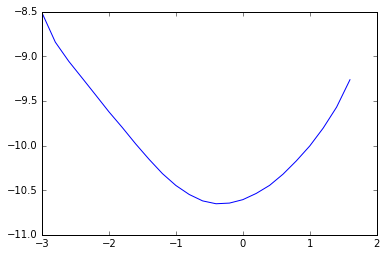

In [81]:
fig4=plt.figure()
plt.plot(d[:-6],xd[:-6,1])
plt.plot(d[:-6],yd[:-6,1])
plt.plot(d[:-6],zd[:-6,1])
plt.show()

Iterate in space

In [85]:
n=(np.arange(9)-2)*5
trajectories=list()
m=0
for i in n:
    for j in n:
        for k in n:
            rd=[i+r0[0],j+r0[1],k+r0[2]]
            
            [ri,v,t]=trajectory(rd,v0,dt)
            trajectories.append(ri)

In [125]:
distance=[np.linalg.norm(goodtra[t][-1]-center) for t in range(len(goodtra))]
ind=distance.index(min(distance))
goodtra[ind][0]

array([ 112.5,  102.5,   55. ])

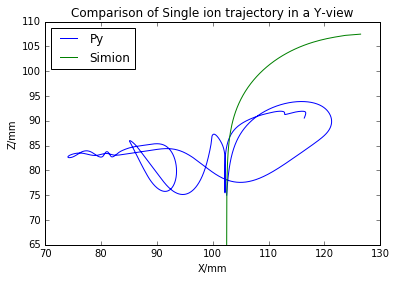

In [53]:
%matplotlib inline
trj2=plt.figure()
xt=r[:,0]
yt=r[:,1]
zt=r[:,2]
plt.plot(xt,zt,label="Py")
plt.plot(sim_x,sim_z,label="Simion")
plt.title("Comparison of Single ion trajectory in a Y-view")
plt.xlabel("X/mm")
plt.ylabel("Z/mm")
plt.legend(loc='best')
plt.show()

In [49]:
r[-1],[sim_x[-1],sim_y[-1],sim_z[-1]]

(array([ 126.52150501,  102.79075931,  107.46110422]),
 [126.5, 102.794, 107.473])

In [51]:
final=r[-1]

In [52]:
np.sqrt((final[0]-sim_x[-1])**2+(final[1]-sim_y[-1])**2+(final[2]-sim_z[-1])**2)

0.02478864480323659

In [53]:
final[0]-sim_x[-1]

0.021505007633507489

In [54]:
final[1]-sim_y[-1]

-0.0032406853697466431

In [55]:
final[2]-sim_z[-1]

-0.011895777242287409

In [96]:
len(trajectories)

1000

In [148]:
mask=np.linalg.norm(endpoints-center,axis=1)<7.25

In [149]:
mask

array([False, False, False, ..., False, False, False], dtype=bool)

In [156]:
goodpoints=np.array(endpoints)[mask==True]

In [157]:
np.linalg.norm(goodpoints-center,axis=1)

array([ 7.22087448,  7.13324227,  6.63440187,  7.24903685,  6.99950757,
        7.20558012,  7.14494744,  7.20633749,  7.21420242,  7.10220518,
        6.8211641 ,  6.96244569,  6.46023638,  6.85627853,  6.81013352,
        6.43182284,  6.81282371,  7.04611425,  6.92583235,  6.10018987,
        6.89162514,  6.9637142 ,  6.41304429,  6.74214691,  7.22793138,
        7.09658391,  6.90625046,  7.24961524,  7.19900497,  6.8139319 ,
        6.6622776 ,  6.73009007,  7.03778739,  6.81362537,  6.61294217,
        6.71846578,  6.97445292,  7.09241845,  6.90450909,  7.0077481 ,
        7.06915767,  7.21897164,  7.02382148,  6.91776135,  6.89615776,
        7.21644392,  6.68194655,  6.99262678,  7.08500829,  7.00929481,
        7.02133545,  6.80193592,  7.20342928,  6.65508738,  6.62653784,
        6.70038213,  7.15254014,  6.84869062,  6.5436557 ,  7.20307941,
        7.0761822 ,  6.85625512,  6.87387059,  5.85121826])

In [141]:
print np.linalg.norm(displacement[:2])
print np.linalg.norm(displacement)
print np.linalg.norm(displacement[:1])
print displacement[0]
print displacement

0.54652511296
0.550476052172
0.546129784722
0.546129784722
[ 0.54612978 -0.02078358 -0.06583453]


In [17]:
d=np.linspace(5.e-4,0.01,10)

array([ 0.0005    ,  0.00155556,  0.00261111,  0.00366667,  0.00472222,
        0.00577778,  0.00683333,  0.00788889,  0.00894444,  0.01      ])

In [182]:
import time

In [102]:
import time
start=time.time()
[f10,v10]=trajectory2(r0,v0,dt)
end=time.time()
print end-start

1.84500002861


In [108]:
(end-start)*800/60

24.600000381469727

In [122]:
d=np.arange(0,13,0.1)
zd=np.zeros((len(d),4))
for k in range(len(d)):
    rr=np.array([102.5+d[k],102.5,65.])
    [r,v]=trajectory2(rr,v0,dt)
    zd[k,0]=rr[2]
    zd[k,1]=r[0]
    zd[k,2]=r[1]
    zd[k,3]=r[2]
    
    print rr,r

[ 102.5  102.5   65. ] [-10.606380110425652, 0.32024549027025273, 3.292320197611649]
[ 102.6  102.5   65. ] [-10.541193373067108, 0.31827336146832863, 3.2961280555731922]
[ 102.7  102.5   65. ] [-10.468838847312353, 0.31690170991998912, 3.2819112580843162]
[ 102.8  102.5   65. ] [-10.394053606348695, 0.31481674243090652, 3.2861401926573697]
[ 102.9  102.5   65. ] [-10.325236671500251, 0.31392505684584648, 3.2704780748896698]
[ 103.   102.5   65. ] [-10.243657941599217, 0.31128210451718985, 3.2757496312493926]
[ 103.1  102.5   65. ] [-10.170914833687133, 0.30995179113050142, 3.2774293326895036]
[ 103.2  102.5   65. ] [-10.08213918157897, 0.30936948304123746, 3.2617884534852379]
[ 103.3  102.5   65. ] [-10.001267201788334, 0.30731633580498396, 3.2652117188319791]
[ 103.4  102.5   65. ] [-9.9154779247340521, 0.30475349249630312, 3.268753273253215]
[ 103.5  102.5   65. ] [-9.8210584958167839, 0.30362158551210428, 3.26961665656829]
[ 103.6  102.5   65. ] [-9.7328774658695068, 0.304325146631

(-10, 10)

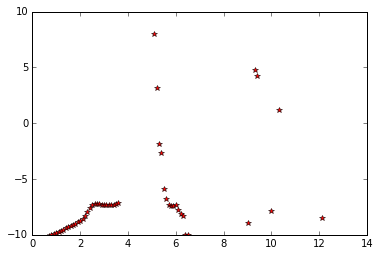

In [162]:
plt.plot(d[:],zd[:,1],'r*')
plt.ylim([-10,10])
#plt.xlim([-10,10])

In [21]:
import time

In [54]:
xc=np.linspace(92.5,112.5,11)
yc=np.linspace(92.5,112.5,11)
zc=np.linspace(55,68,14)
startpoints=np.zeros((len(xc)*len(yc)*len(zc),3))
finalpoints=np.zeros((len(xc)*len(yc)*len(zc),3))
v=np.zeros((1,3))
ind=0
start=time.time()
for i in xc:
    for j in yc:
        for k in zc:
            startpoints[ind]=np.array([i,j,k])
            [finalpoints[ind],v]=trajectory2(startpoints[ind],v0,dt)
            ind +=1
            print (time.time()-start)/60.
end=time.time()

0.0438833316167
0.0806666652362
0.128583331903
0.165366665522
0.193883331617
0.209466663996
0.223849999905
0.237749997775
0.257933330536
0.270816663901
0.297683334351
0.325033330917
0.376499998569
0.428133332729
0.445266664028
0.459750000636
0.473583332698
0.486933330695
0.500916667779
0.513533333937
0.532366665204
0.550433333715
0.567683331172
0.607299999396
0.643449997902
0.671999998887
0.716733332475
0.848666663965
0.866783332825
0.880616664886
0.893783330917
0.907666667302
0.921233332157
0.934816666444
0.947516663869
0.959849997362
0.972233331203
0.985250000159
0.997250000636
1.01071666479
1.02513333162
1.04061666727
1.05313333273
1.0662833333
1.07928333282
1.09228333235
1.10676666498
1.12285000086
1.14169999758
1.15738333066
1.1699666659
1.18226666451
1.19419999917
1.2076666673
1.22193333308
1.23893333276
1.25288333098
1.26758333445
1.28258333206
1.29744999806
1.31218333244
1.32648333311
1.34066666762
1.35441666444
1.36783333222
1.38111666441
1.39399999777
1.40679999987
1.42044999

In [90]:
search=h5py.File('Searching for atom cloud position.hdf5','w')

In [91]:
recordstartpoints=search.create_dataset("startpoints",(startpoints.shape),dtype=np.float64)

In [92]:
recordstartpoints[...]=startpoints

In [93]:
recordfinalpoints=search.create_dataset("finalpoints",(finalpoints.shape),dtype=np.float64)

In [94]:
recordfinalpoints[...]=finalpoints

In [100]:
goodstart=startpoints[np.linalg.norm(finalpoints[:,:2],axis=1) < .35]
print [min(goodstart[:,0]),max(goodstart[:,0])],[min(goodstart[:,1]),max(goodstart[:,1])],[min(goodstart[:,2]),max(goodstart[:,2])]
print goodstart

[94.5, 94.5] [102.5, 102.5] [55.0, 56.0]
[[  94.5  102.5   55. ]
 [  94.5  102.5   56. ]]


In [101]:
goodfinal=finalpoints[np.linalg.norm(finalpoints[:,:2],axis=1) < .4]
print goodfinal

[[ 0.2997091   0.07147165  4.47158952]
 [ 0.12184807  0.0724092   4.51760273]]


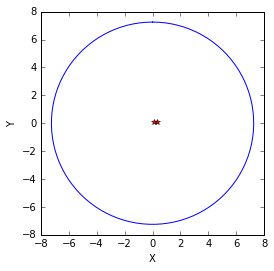

In [102]:
goodfinal=finalpoints[np.linalg.norm(finalpoints[:,:2],axis=1) < .4]
theta=np.linspace(0,2*np.pi,100)
plt.plot(7.25*np.sin(theta),7.25*np.cos(theta))
plt.plot(goodfinal[:,0],goodfinal[:,1],'r*')
plt.axes().set_aspect('equal')
plt.xlabel("X")
plt.ylabel("Y")
plt.show()

<IPython.core.display.Javascript object>


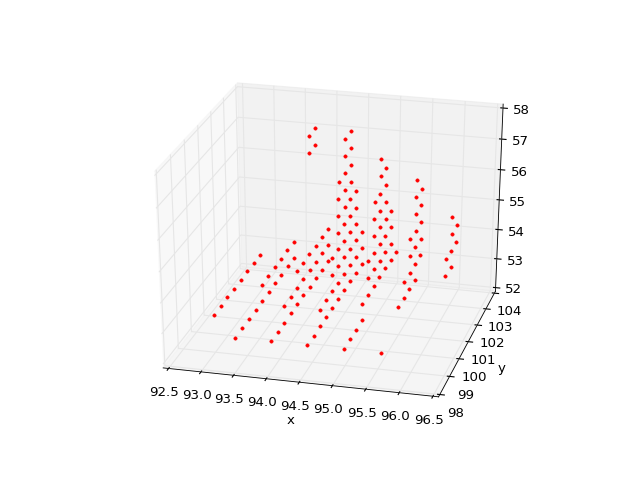

In [25]:
%matplotlib notebook
goodfig=plt.figure()
volume=goodfig.add_subplot(111,projection='3d')
volume.plot(goodstart[:,0],goodstart[:,1],goodstart[:,2],'r.')
plt.xlabel("x")
plt.ylabel("y")
#plt.zlabel("z")
plt.show()

In [225]:
#94.72222222  101.38888889   55.
import time
xc=np.linspace(94.5 - 0.05,94.5 + 0.05,10)
yc=np.linspace(102.5 - 0.01,102.5 + 0.01,10)
zc=np.linspace(55.5 - 0.01,55.5 + 0.01,10)
startpoints=np.zeros((len(xc)*len(yc)*len(zc),3))
finalpoints=np.zeros((len(xc)*len(yc)*len(zc),3))
v=np.zeros((1,3))
ind=0
start=time.time()
for i in xc:
    for j in yc:
        for k in zc:
            startpoints[ind]=np.array([i,j,k])
            [finalpoints[ind],v]=trajectory2(startpoints[ind],v0,dt)
            ind +=1
            print (time.time()-start)/60.
            
end=time.time()

0.0410333355268
0.0906833370527
0.130366667112
0.165700002511
0.198666667938
0.232566670577
0.252983335654
0.269500001272
0.285266669591
0.313083334764
0.330200000604
0.344366669655
0.359133334955
0.371800001462
0.386466670036
0.40163333416
0.418133334319
0.434583334128
0.450650000572
0.476350001494
0.517616669337
0.544950000445
0.569716668129
0.587483334541
0.600433333715
0.615600001812
0.630266670386
0.645316668351
0.659250001113
0.673250003656
0.687750001748
0.704683335622
0.723733333747
0.744116667906
0.761883334319
0.781316669782
0.805233335495
0.82523333629
0.841083335876
0.856650002797
0.873366669814
0.889383335908
0.904950002829
0.920300002893
0.936366669337
0.953250002861
0.968616668383
0.984666669369
1.00148333708
1.01461666822
1.03211666743
1.04863333702
1.06541666985
1.08191667
1.09795000156
1.11503333648
1.13103333712
1.14736666679
1.1618500034
1.17676666975
1.19551666975
1.21230000257
1.22960000038
1.24760000308
1.2636500001
1.2774666667
1.29140000343
1.31383333604
1.3363

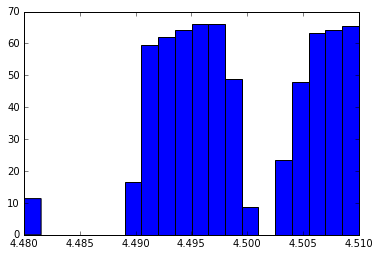

In [160]:
count, bins, ignored = plt.hist(finalpoints[:,2], 20, normed=True)

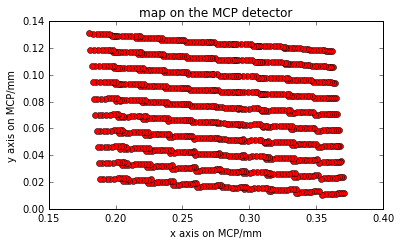

In [168]:
plt.plot(finalpoints[:,0],finalpoints[:,1],'ro')
#theta=np.linspace(0,2*np.pi,100)
#plt.plot(7.25*np.sin(theta),7.25*np.cos(theta))
plt.axes().set_aspect('equal')
plt.title("map on the MCP detector")
plt.xlabel("x axis on MCP/mm")
plt.ylabel("y axis on MCP/mm")
plt.show()

#### Change deflection ring 1 voltage from 0.3 to 10

In [213]:
#set values of 19 electrodes, for ionization field of state n=30
electrode_set_potentials=[187.,187.,-1.74,-278.,-0.114,-1900.,0.,3.97,-1.74,-278.,187.,187.,0.3,-278.,0.,0.,0.,0.318,0.307]
# generate potential by setting each electrode to its potential and adding up all electrodes' potential
vd1=np.linspace(0,20,11)
print type(electrode_set_potentials)
print vd1

<type 'list'>
[  0.   2.   4.   6.   8.  10.  12.  14.  16.  18.  20.]


In [214]:
hope=np.zeros((len(vd1),3))
v=np.zeros((1,3))
r0=np.array([94.5,102.5,55.5])
#r0=np.array([102.5,102.5,65.])
v0=np.array([0,0,0])
for i in range(len(vd1)):
    electrode_set_potentials[12]=vd1[i]
    potentials=np.zeros((len(x),len(y),len(z)))
    for k in range(19):
        electroden=f["Potential Arrays/electrode"+str(k+1)].value
        potentials+=electrode_set_potentials[k]*electroden/10000.
    p_interpolation=rgi((x,y,z),potentials)
    [hope[i,:],v]=trajectory2(r0,v0,dt)
    print np.linalg.norm(hope[i,:2]),hope[i,2]
    
electrode_set_potentials=[187.,187.,-1.74,-278.,-0.114,-1900.,0.,3.97,-1.74,-278.,187.,187.,0.3,-278.,0.,0.,0.,0.318,0.307]

0.298205250859 4.49104471873
0.26215151028 4.49575837741
0.350307405256 4.48032303264
0.499568199757 4.48490460089
0.668424904283 4.48927696913
0.837212987813 4.47361587669
1.01256976765 4.47778574967
1.17910272691 4.46182175363
1.35155685314 4.46565183796
1.52438059656 4.46917286417
1.67476464344 4.45271356973


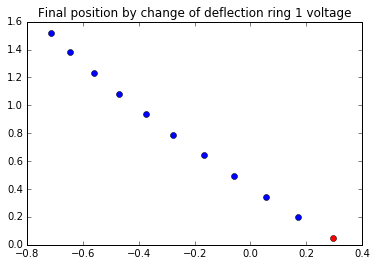

In [215]:
plt.plot(hope[0,0],hope[0,1],'ro')
plt.plot(hope[1:,0],hope[1:,1],'o')
plt.title("Final position by change of deflection ring 1 voltage")
plt.show()

#### Change f1 and f2 above (low voltage electrodes)

In [219]:
#set values of 19 electrodes, for ionization field of state n=30
electrode_set_potentials=[187.,187.,-1.74,-278.,-0.114,-1900.,0.,3.97,-1.74,-278.,187.,187.,0.3,-278.,0.,0.,0.,0.318,0.307]
vf1above=np.linspace(0,10,11)
print vf1above

[  0.   1.   2.   3.   4.   5.   6.   7.   8.   9.  10.]


In [220]:
hope=np.zeros((len(vf1above),3))
v=np.zeros((1,3))
r0=np.array([94.5,102.5,55.5])
#r0=np.array([102.5,102.5,65.])
v0=np.array([0,0,0])
for i in range(len(vf1above)):
    electrode_set_potentials[2]=vf1above[i]
    electrode_set_potentials[8]=vf1above[i]
    potentials=np.zeros((len(x),len(y),len(z)))
    for k in range(19):
        electroden=f["Potential Arrays/electrode"+str(k+1)].value
        potentials+=electrode_set_potentials[k]*electroden/10000.
    p_interpolation=rgi((x,y,z),potentials)
    [hope[i,:],v]=trajectory2(r0,v0,dt)
    print np.linalg.norm(hope[i,:2]),hope[i,2]

0.126733394041 4.4976701006
0.132352055105 4.48112000486
0.214263828538 4.48444371119
0.31574714852 4.48758899428
0.421032130041 4.47089633303
0.528148382512 4.47398117834
0.632605344582 4.47705665551
0.733351327186 4.46006080985
0.834406856925 4.46287095222
0.934158909652 4.46570415123
1.03263353442 4.46827041587


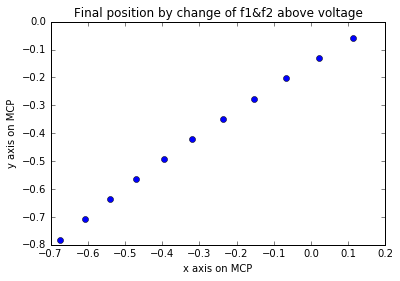

In [222]:
plt.plot(hope[:,0],hope[:,1],'o')
plt.title("Final position by change of f1&f2 above voltage")
plt.xlabel("x axis on MCP")
plt.ylabel("y axis on MCP")
plt.show()

Change  f3

In [190]:
#set values of 19 electrodes, for ionization field of state n=30
electrode_set_potentials=[187.,187.,-1.74,-278.,-0.114,-1900.,0.,3.97,-1.74,-278.,187.,187.,0.3,-278.,0.,0.,0.,0.318,0.307]
# generate potential by setting each electrode to its potential and adding up all electrodes' potential
vf3above=np.linspace(0,100,11)
print vf3above

[   0.   10.   20.   30.   40.   50.   60.   70.   80.   90.  100.]


In [223]:
hope=np.zeros((len(vf3above),3))
v=np.zeros((1,3))
r0=np.array([94.5,102.5,55.5])
#r0=np.array([102.5,102.5,65.])
v0=np.array([0,0,0])
for i in range(len(vf1above)):
    electrode_set_potentials[2]=vf1above[i]
    electrode_set_potentials[8]=vf1above[i]
    potentials=np.zeros((len(x),len(y),len(z)))
    for k in range(19):
        electroden=f["Potential Arrays/electrode"+str(k+1)].value
        potentials+=electrode_set_potentials[k]*electroden/10000.
    p_interpolation=rgi((x,y,z),potentials)
    [hope[i,:],v]=trajectory2(r0,v0,dt)
    print np.linalg.norm(hope[i,:2]),hope[i,2]

0.126733394041 4.4976701006
0.132352055105 4.48112000486
0.214263828538 4.48444371119
0.31574714852 4.48758899428
0.421032130041 4.47089633303
0.528148382512 4.47398117834
0.632605344582 4.47705665551
0.733351327186 4.46006080985
0.834406856925 4.46287095222
0.934158909652 4.46570415123
1.03263353442 4.46827041587


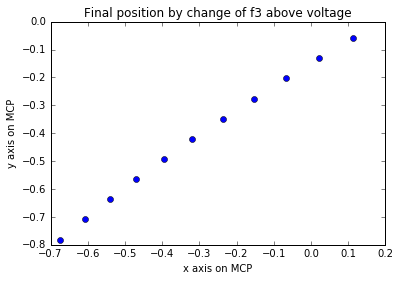

In [224]:
plt.plot(hope[:,0],hope[:,1],'o')
plt.title("Final position by change of f3 above voltage")
plt.xlabel("x axis on MCP")
plt.ylabel("y axis on MCP")
plt.show()